In [1]:
import joblib
from collections import Counter

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, make_scorer
from scipy.stats import uniform, randint
import xgboost as xgb

## Evaluation Methods

In order to find the optimal model, F_beta score is applied in cross validation. beta equals to 2 indicates that we have a higher weight on the recall when selecting models . In other words, type II error will be weigh higher.

When evaluating the test data, the main measure for deciding the optimal model will be the challenge metric (Total cost = Cost1 · `#type I failures` + Cost2 · `#type II failures`). Besides, F_beta score and classification reports of precision/recall will be applied when running the script as a reference for the model performance. Together with challenge metrics, F_beta scores are recorded as F2 scores.

`#type I failures` is the count of type I failures (false positive), which indicates no faulty systems were reported positive falsely and leads to unnecessary mechanical check. While `#type II failures` is the count of type II failures (false negative), which indicates these problematic systems were reported no failure. The costs are 10 and 500 respectively.

## Load data

In [2]:
data = pd.read_csv('../data/ida_2016_training_set_update.csv', na_values=['na'])

In [3]:
list(data.columns)

['class',
 'aa_000',
 'ab_000',
 'ac_000',
 'ad_000',
 'ae_000',
 'af_000',
 'ag_000',
 'ag_001',
 'ag_002',
 'ag_003',
 'ag_004',
 'ag_005',
 'ag_006',
 'ag_007',
 'ag_008',
 'ag_009',
 'ah_000',
 'ai_000',
 'aj_000',
 'ak_000',
 'al_000',
 'am_0',
 'an_000',
 'ao_000',
 'ap_000',
 'aq_000',
 'ar_000',
 'as_000',
 'at_000',
 'au_000',
 'av_000',
 'ax_000',
 'ay_000',
 'ay_001',
 'ay_002',
 'ay_003',
 'ay_004',
 'ay_005',
 'ay_006',
 'ay_007',
 'ay_008',
 'ay_009',
 'az_000',
 'az_001',
 'az_002',
 'az_003',
 'az_004',
 'az_005',
 'az_006',
 'az_007',
 'az_008',
 'az_009',
 'ba_000',
 'ba_001',
 'ba_002',
 'ba_003',
 'ba_004',
 'ba_005',
 'ba_006',
 'ba_007',
 'ba_008',
 'ba_009',
 'bb_000',
 'bc_000',
 'bd_000',
 'be_000',
 'bf_000',
 'bg_000',
 'bh_000',
 'bi_000',
 'bj_000',
 'bk_000',
 'bl_000',
 'bm_000',
 'bn_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'bs_000',
 'bt_000',
 'bu_000',
 'bv_000',
 'bx_000',
 'by_000',
 'bz_000',
 'ca_000',
 'cb_000',
 'cc_000',
 'cd_000',
 '

In [4]:
# Split into X and y
X, y = data.drop(['class'], axis=1), data['class']

In [5]:
# Split into training/testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

## XGBoost (without imputation of missing data)

In [6]:
# Function to get the total cost (competition metric)
def get_total_cost(type1_error, type2_error, cost1 = 10, cost2 = 500):
    # type II error: FN, cost=500
    # type I error: FP, cost=10
    return type1_error*cost1 + type2_error*cost2

In [7]:
# Function to get prettified confusion matrix
def get_confusion_matrix(y_pred, y_true=y_test):
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true, y_pred, labels=['pos', 'neg']),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
    
    return confusion_matrix_df

In [8]:
def f_beta_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    beta = 2 # Less weight on precision, more weight on recall
    return 'ftwo_score', fbeta_score(y_pred, y_true, beta)

There are four separate approaches in XGBoost:
1. The first model is trained with default parameters as a baseline for comparison. 
2. There is another one with defined ‘scale_pos_weight’ as proportion between negative to positive cases (59). 
3. From the grid search CV models, we intend to find the optimal ‘scale_pos_weight’ from a range of possible values; 
4. While the randomized search CV model is to find a set of optimal parameters from provided parameter distribution. 

### Baseline - default parameters

In [15]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr', random_state=3)

In [16]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=3, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [17]:
y_pred = xgb_model.predict(X_test)

In [18]:
conf_mat = get_confusion_matrix(y_pred)
print(f'Confusion matrix:\n {conf_mat}')

Confusion matrix:
           Pred:pos  Pred:neg
True:pos       149        51
True:neg        14     11786


In [19]:
total_cost = get_total_cost(type1_error=14, type2_error=51)
print(f'Total cost: {total_cost}')

Total cost: 25640


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     11800
         pos       0.91      0.74      0.82       200

    accuracy                           0.99     12000
   macro avg       0.95      0.87      0.91     12000
weighted avg       0.99      0.99      0.99     12000



In [21]:
ftwo_score = fbeta_score(y_test, y_pred, beta=2, pos_label='pos')

print(f'F2 score: {ftwo_score}')

F2 score: 0.7736240913811007


### Making use of 'sclae_pos_weight' parameter

'scale_pos_weight' value is used to scale the gradient for the positive class.

In [22]:
# count examples in each class
counter = Counter(y_train)

# estimate scale_pos_weight value
estimate = counter['neg'] / counter['pos'] # scale_pos_weight = total_negative_examples / total_positive_examples
print(estimate)

59.0


In [23]:
# define model
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr', random_state=3, scale_pos_weight=estimate)

In [24]:
xgb_model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=3, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=59.0, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [25]:
y_pred2 = xgb_model2.predict(X_test)

In [26]:
# Evaluation on test data set
conf_mat2 = get_confusion_matrix(y_pred2)
print(f'Confusion matrix:\n {conf_mat2}')

Confusion matrix:
           Pred:pos  Pred:neg
True:pos       169        31
True:neg        23     11777


In [27]:
total_cost2 = get_total_cost(type1_error=23, type2_error=31)
print(f'Total cost: {total_cost2}')

Total cost: 15730


In [28]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     11800
         pos       0.88      0.84      0.86       200

    accuracy                           1.00     12000
   macro avg       0.94      0.92      0.93     12000
weighted avg       1.00      1.00      1.00     12000



In [29]:
ftwo_score2 = fbeta_score(y_test, y_pred2, beta=2, pos_label='pos')

print(f'F2 score: {ftwo_score2}')

F2 score: 0.8518145161290323


### Grid search CV

In [30]:
# Define a 5-fold splits in applying CV, random_state is fixed
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [31]:
# define grid
param_grids = {'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000]} # deafult=1

In [32]:
ftwo_scorer = make_scorer(fbeta_score, beta=2, pos_label='pos')

In [33]:
xgb_model3 = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr', random_state=3)

# define grid search
grid_search_cv_models = GridSearchCV(estimator=xgb_model3, param_grid=param_grids, n_jobs=1, scoring=ftwo_scorer, cv=fold, verbose=1, return_train_score=True)

In [34]:
# execute the grid search
grid_search_cv_models.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 44.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='aucpr',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=3,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                              

In [35]:
print(f'The best score during training: {grid_search_cv_models.best_score_}, with params: {grid_search_cv_models.best_params_}')

The best score during training: 0.8011889992579281, with params: {'scale_pos_weight': 99}


In [ ]:
# grid_search_cv_models.cv_results_

In [54]:
with open('../models/grid_search_cv_models.pkl', 'wb') as pickled_file: 
    joblib.dump(grid_search_cv_models, pickled_file)

In [36]:
y_pred3 = grid_search_cv_models.predict(X_test)

In [37]:
conf_mat3 = get_confusion_matrix(y_pred3)
print(f'Confusion matrix:\n {conf_mat3}')

Confusion matrix:
           Pred:pos  Pred:neg
True:pos       166        34
True:neg        34     11766


In [38]:
total_cost3 = get_total_cost(type1_error=34, type2_error=34)
print(f'Total cost: {total_cost3}')

Total cost: 17340


In [39]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     11800
         pos       0.83      0.83      0.83       200

    accuracy                           0.99     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.99      0.99      0.99     12000



In [40]:
ftwo_score3 = fbeta_score(y_test, y_pred3, beta=2, pos_label='pos')

print(f'F2 score: {ftwo_score3}')

F2 score: 0.83


### Randomized search  CV

In [41]:
# Define parameter distribution for Randomized search CV
param_distributions = {
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'learning_rate': uniform(0.03, 0.3), # default 0.1 
    'max_depth': randint(2, 6), # default 3
    'n_estimators': randint(100, 150), # default 100
    'subsample': uniform(0.6, 0.4)
}

In [42]:
xgb_model4 = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr', random_state=3)

random_search_cv_models = RandomizedSearchCV(xgb_model4, param_distributions=param_distributions, scoring=ftwo_scorer, random_state=3, n_iter=10, cv=fold, verbose=1, n_jobs=1, return_train_score=True)

In [43]:
random_search_cv_models.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 32.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='aucpr', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11d733f70>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen 

In [46]:
print(f'The best score during training: {random_search_cv_models.best_score_}, with params: {random_search_cv_models.best_params_}')

The best score during training: 0.7557770545133612, with params: {'colsample_bytree': 0.8772588452249052, 'gamma': 0.011990941188582682, 'learning_rate': 0.1976562263972646, 'max_depth': 3, 'n_estimators': 140, 'subsample': 0.7660404788040278}


In [45]:
with open('../models/random_search_cv_models.pkl', 'wb') as pickled_file: 
    joblib.dump(random_search_cv_models, pickled_file)

In [47]:
y_pred4 = random_search_cv_models.predict(X_test)

In [48]:
conf_mat4 = get_confusion_matrix(y_pred4)
print(f'Confusion matrix:\n {conf_mat4}')

Confusion matrix:
           Pred:pos  Pred:neg
True:pos       148        52
True:neg        12     11788


In [49]:
total_cost4 = get_total_cost(type1_error=12, type2_error=52)
print(f'Total cost: {total_cost4}')

Total cost: 26120


In [50]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     11800
         pos       0.93      0.74      0.82       200

    accuracy                           0.99     12000
   macro avg       0.96      0.87      0.91     12000
weighted avg       0.99      0.99      0.99     12000



In [51]:
ftwo_score4 = fbeta_score(y_test, y_pred4, beta=2, pos_label='pos')

print(f'F2 score: {ftwo_score4}')

F2 score: 0.7708333333333333


### Visualization for the best model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

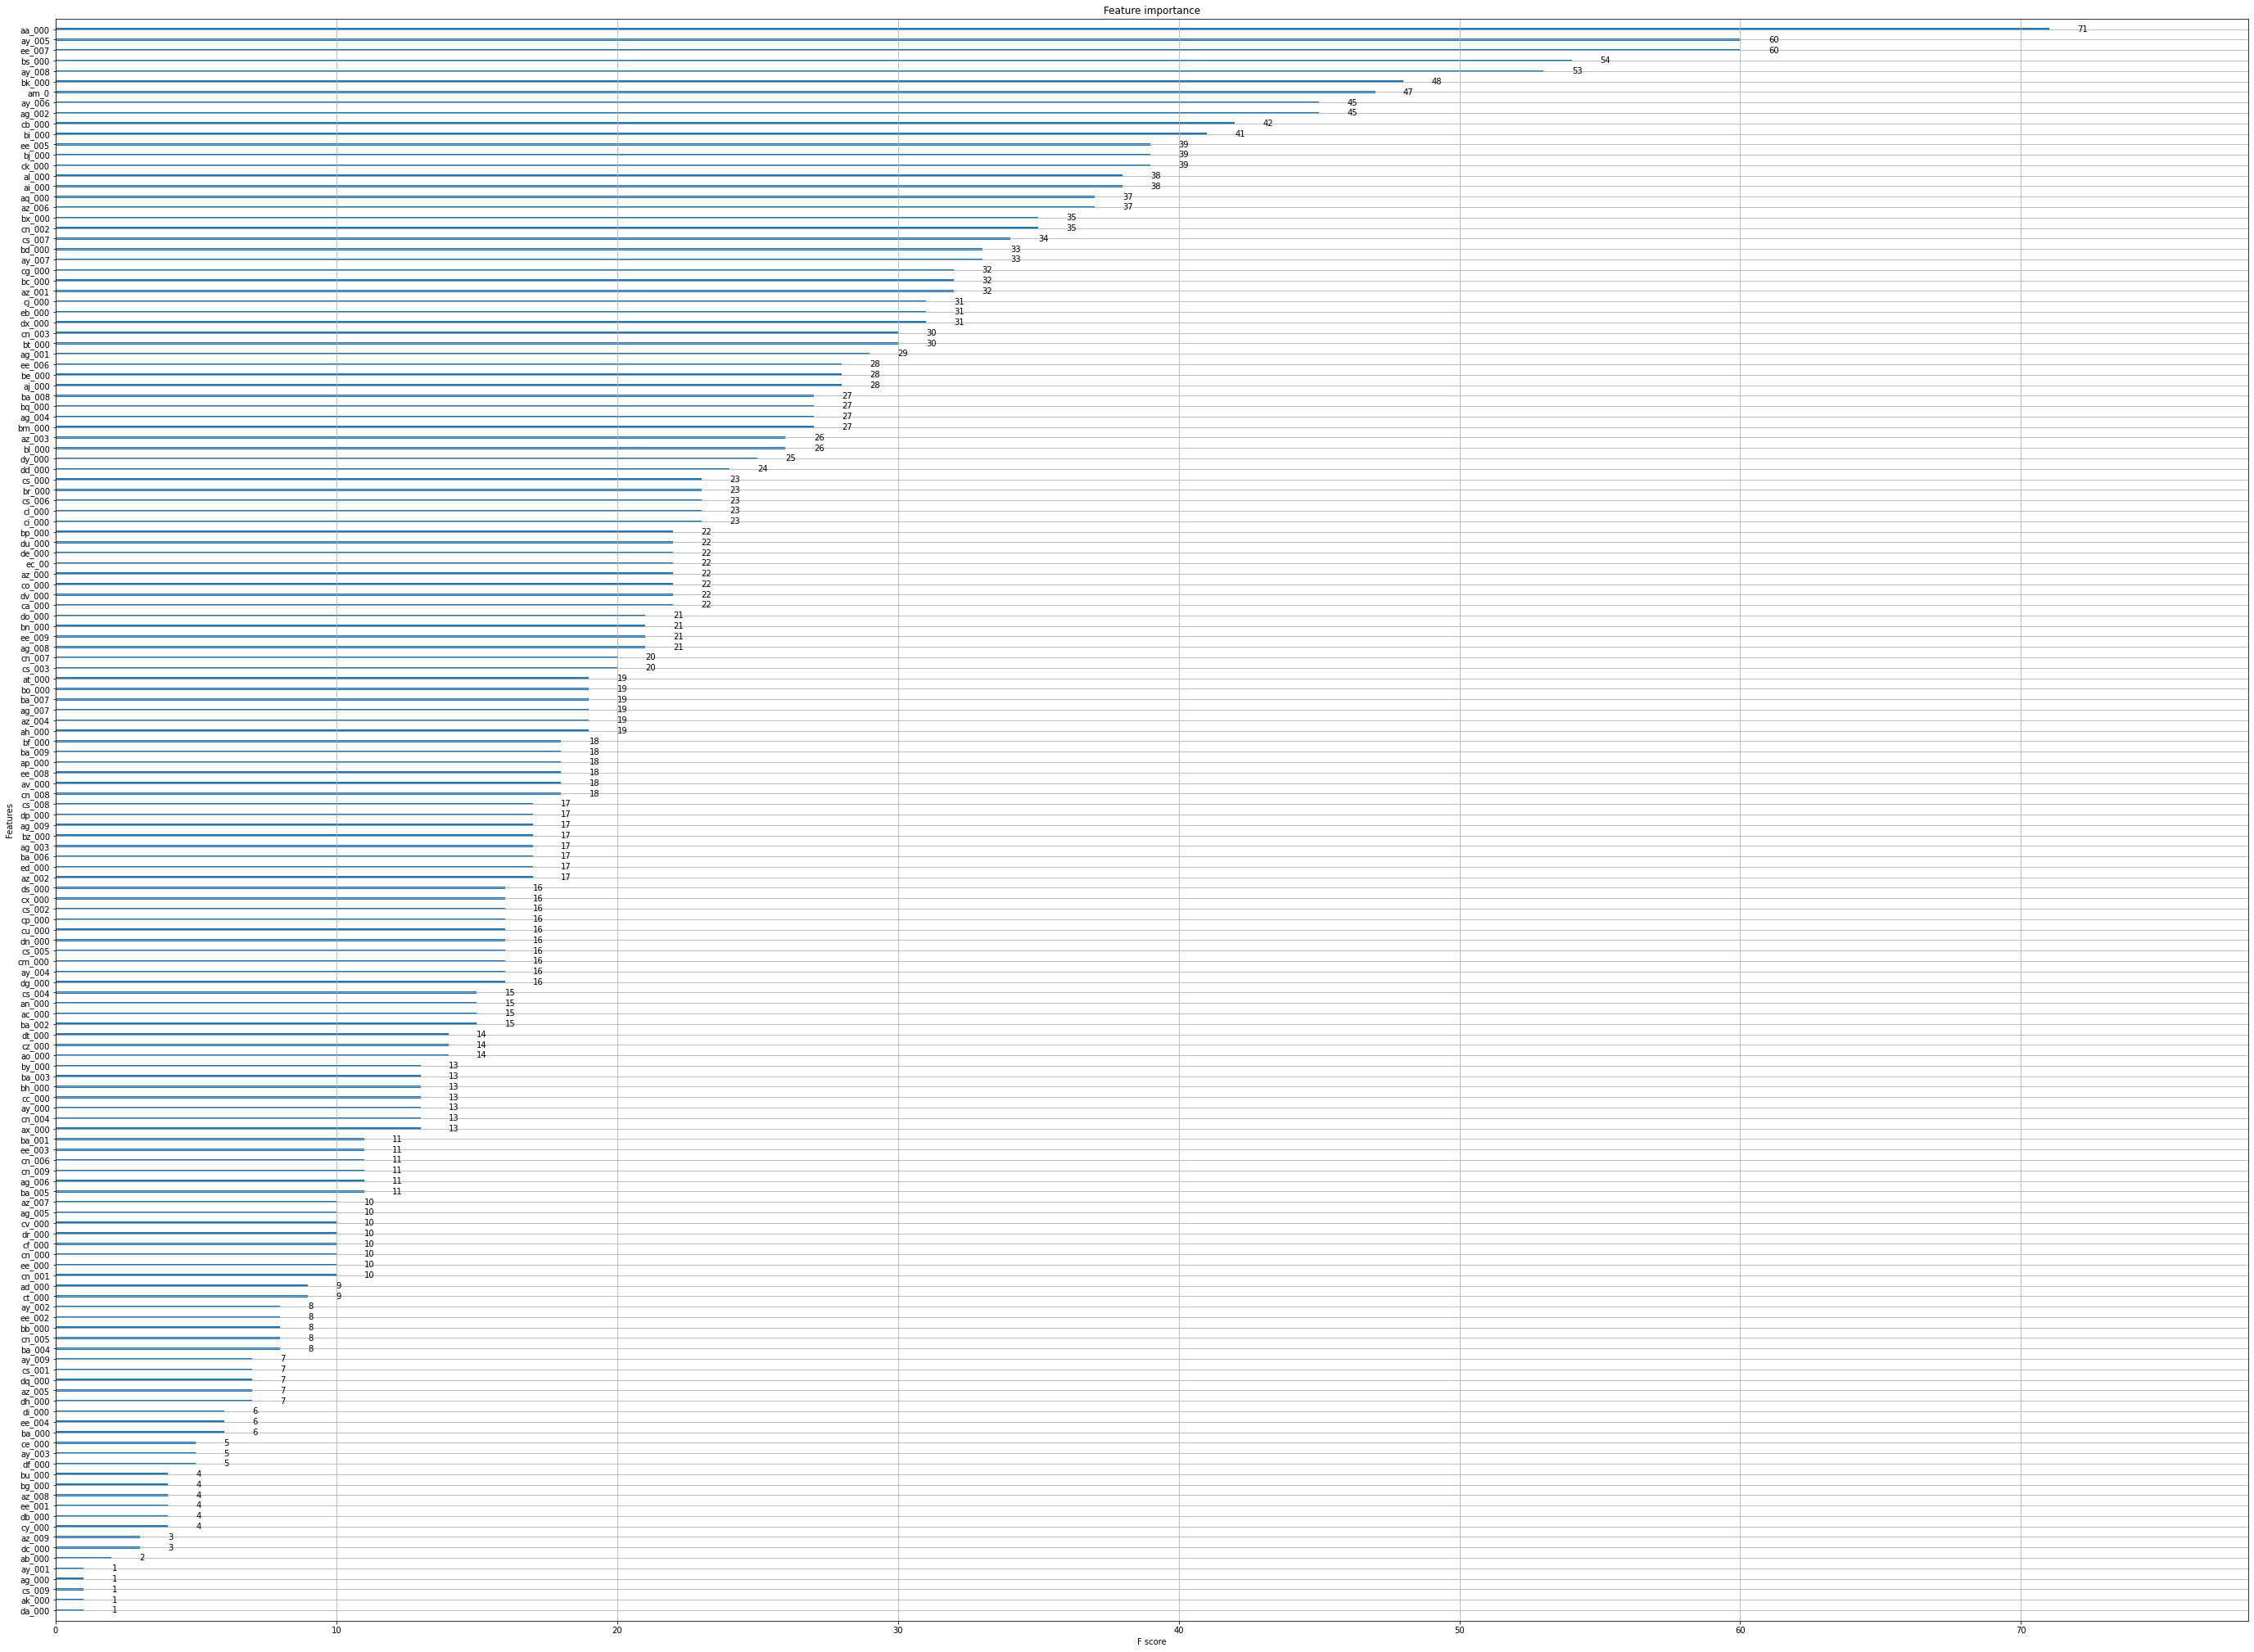

In [52]:
import graphviz
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(48, 36))
xgb.plot_importance(xgb_model2, ax=ax)


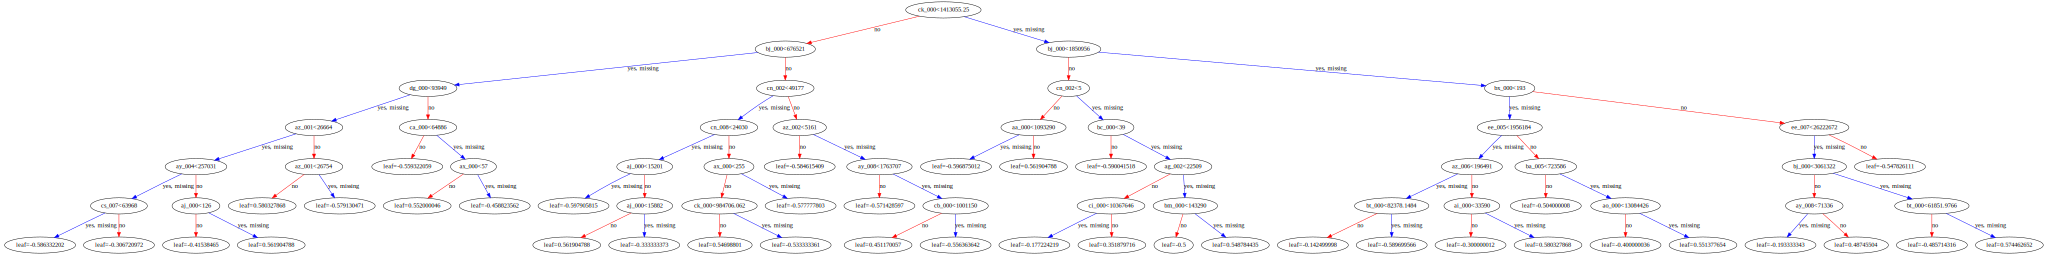

In [53]:
# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model2)